In [3]:
pip install numpy pandas scikit-learn xgboost shap matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Load and prepare data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(X_train.head())

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
68         9.029         17.33           58.79      250.5          0.10660   
181       21.090         26.57          142.70     1311.0          0.11410   
63         9.173         13.86           59.20      260.9          0.07721   
248       10.650         25.22           68.01      347.0          0.09657   
60        10.170         14.88           64.55      311.9          0.11340   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
68            0.14130         0.31300              0.04375         0.2111   
181           0.28320         0.24870              0.14960         0.2395   
63            0.08751         0.05988              0.02180         0.2341   
248           0.07234         0.02379              0.01615         0.1897   
60            0.08061         0.01084              0.01290         0.2743   

     mean fractal dimension  ...  worst radius  worst texture  \
68 


=== PCA Dimensionality Reduction ===
Explained Variance Ratio: [0.43502782 0.19500007]
Total Explained Variance: 0.6300278846854036


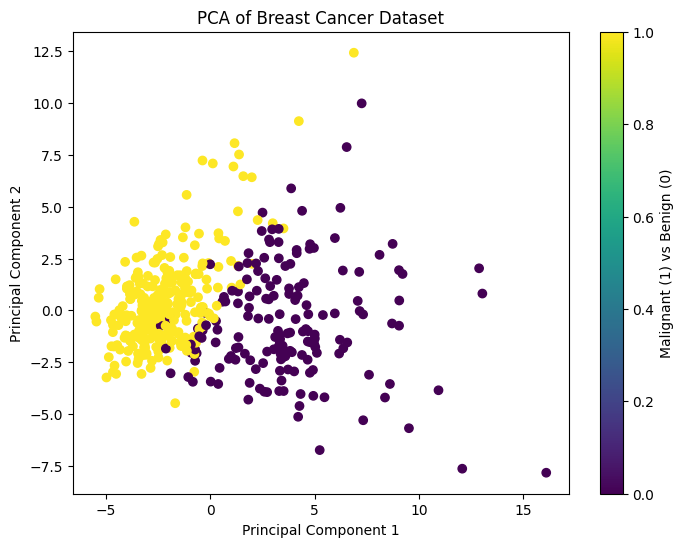

In [3]:

# 1. PCA for Dimensionality Reduction
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance:", sum(pca.explained_variance_ratio_))

# Plot PCA
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Breast Cancer Dataset')
plt.colorbar(label='Malignant (1) vs Benign (0)')
plt.show()



=== XGBoost Feature Importance ===

Gain-based Feature Importance:
mean concave points     0.400554
worst concave points    0.184009
worst area              0.066541
worst perimeter         0.056906
worst radius            0.054863
dtype: float32


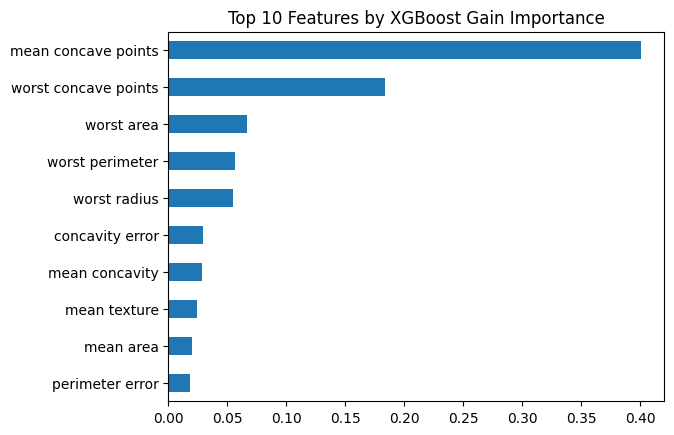

In [5]:

# 2. XGBoost with Feature Importance
print("\n=== XGBoost Feature Importance ===")
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Gain Importance
print("\nGain-based Feature Importance:")
gain_importance = pd.Series(model.feature_importances_, index=data.feature_names)
print(gain_importance.sort_values(ascending=False).head(5))

# Plot Gain Importance
gain_importance.sort_values().tail(10).plot(kind='barh')
plt.title('Top 10 Features by XGBoost Gain Importance')
plt.show()



=== SHAP Feature Importance ===

SHAP Values (Global Importance):
mean concave points     1.344039
worst concave points    0.993054
worst concavity         0.846419
worst area              0.812149
worst texture           0.754799
dtype: float32


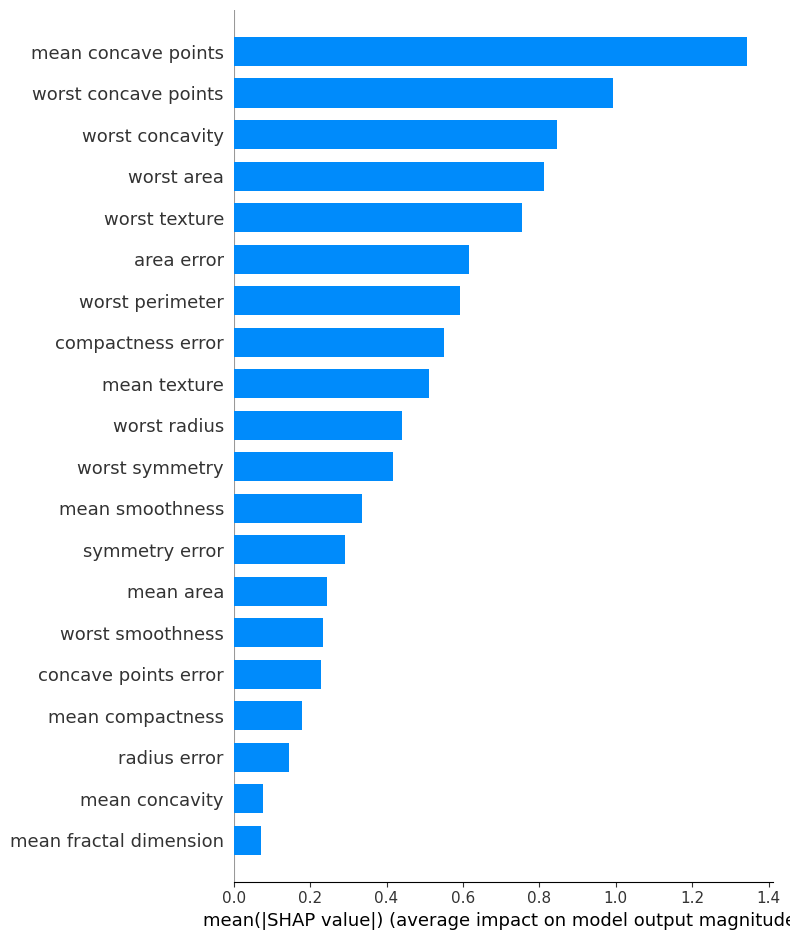

In [6]:

# 3. SHAP Importance
print("\n=== SHAP Feature Importance ===")
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# Global feature importance
print("\nSHAP Values (Global Importance):")
shap_importance = pd.Series(np.abs(shap_values.values).mean(0), index=data.feature_names)
print(shap_importance.sort_values(ascending=False).head(5))

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.show()


In [8]:

# 4. Stability Test with Perturbations
print("\n=== Stability Test ===")
np.random.seed(42)

# Add 10% Gaussian noise
noise = np.random.normal(0, 0.4, size=X_train.shape)
X_noisy = X_train + noise

# Recompute SHAP with noisy data
shap_values_noisy = explainer(X_noisy)
shap_importance_noisy = pd.Series(np.abs(shap_values_noisy.values).mean(0), index=data.feature_names)

# Compare top features
top_original = shap_importance.sort_values(ascending=False).index[0]
top_noisy = shap_importance_noisy.sort_values(ascending=False).index[0]
print(f"\nOriginal top feature: {top_original}")
print(f"Noisy top feature: {top_noisy}")
print(f"Same top feature? {top_original == top_noisy}")

# Compare rankings
print("\nTop 5 Features Comparison:")
print("Original SHAP:", list(shap_importance.sort_values(ascending=False).head(5).index))
print("Noisy SHAP:  ", list(shap_importance_noisy.sort_values(ascending=False).head(5).index))


=== Stability Test ===

Original top feature: mean concave points
Noisy top feature: mean concave points
Same top feature? True

Top 5 Features Comparison:
Original SHAP: ['mean concave points', 'worst concave points', 'worst concavity', 'worst area', 'worst texture']
Noisy SHAP:   ['mean concave points', 'worst concave points', 'worst concavity', 'worst area', 'worst texture']
